In [394]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [570]:
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import glob
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import numpy as np

In [583]:
DATASET_NAME = "mpii"  # mpii, coco

In [584]:
root = f"/hdd/mliuzzolino/CascadedPoseEstimation/results/{DATASET_NAME}"
all_result_paths = glob.glob(f"{root}/*/*")

df_dict = defaultdict(list)
for path in all_result_paths:
  result = np.load(path)
  if not result.shape:
    result = [result]
  basename = os.path.basename(os.path.dirname(path))
  model, td_key = basename.split("__")
  td_key = float(td_key.split("_")[1])
  n_stacks = int(model.split("_x")[1])
  model = model.replace("_", " ")
  
  for t, val in enumerate(result):
    df_dict["model"].append(model)
    df_dict["n_stacks"].append(n_stacks)
    df_dict["t"].append(t)
    df_dict["td"].append(td_key)
    df_dict["val"].append(val)
df = pd.DataFrame(df_dict)

In [585]:
MODEL_NAME = "resnet18"

In [586]:
def split_model(df, model_name=None):
  if model_name:
    model_df = df[df.model==model_name]
  else:
    model_df = df.copy()
  td_model_df = model_df[~model_df["mode"].str.contains("baseline")]
  baseline_df = model_df[model_df["mode"].str.contains("baseline")]
  return td_model_df, baseline_df

In [587]:
def make_color_lookup(df):
  unique_tds = np.sort(td_model_df.td.unique())
  cmap = plt.cm.cool(np.linspace(0, 1, len(unique_tds)+2))[1:-1][:,:3]
  color_lookup = {key: cmap[i] for i, key in enumerate(unique_tds)}
  return color_lookup

In [588]:
def plot_figure(td_model_df, dataset_name, ylim_min=None, ylim_max=None, use_best=True):
  plt.figure(figsize=(8,3))
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  
  if len(td_model_df):
    model_name = td_model_df.model.iloc[0]
    color_lookup = make_color_lookup(td_model_df)

    # TD Model curves
    for td_key, td_df in td_model_df.groupby("td"):
      if use_best:
        asymptotic_val = td_df.val.max()
      else:
        asymptotic_val = td_df[td_df.t==td_df.t.max()].val.iloc[0]
      td_df["td"] = [
          f"CascadedTD({td_key}): {asymptotic_val:0.2f}%" 
          for td_key in td_df["td"]
      ]


      color = color_lookup[td_key]
      palette = sns.set_palette(sns.color_palette([color]))
      g = sns.lineplot(x="t", 
                       y="val", 
                       hue="td", 
                       data=td_df,
                       palette=palette, 
                       linestyle="-",
                       linewidth=2.5)

    plt.suptitle(f"{model_name.capitalize()}, {dataset_name.upper()} Validation Set", fontsize=10)
  else:
    g = plt.gca()
  g.set_title(f"Avg Performance over All Joints", fontsize=8)
  g.set_xlabel("Timestep, t")
  g.set_ylabel("Accuracy (%)")

  handles, labels = g.get_legend_handles_labels()
  
  if ylim_max:
    plt.ylim(ylim_min, ylim_max)
    
  g.xaxis.set_major_locator(MaxNLocator(integer=True))
  
  leg = plt.legend(handles, labels, loc="lower right", prop={'size': 8})

  plt.show()
  plt.clf()

In [589]:
for model_key, td_model_df in df.groupby("model"):
  for td_key, td_df in td_model_df.groupby("td"):
    break

<Figure size 640x480 with 0 Axes>

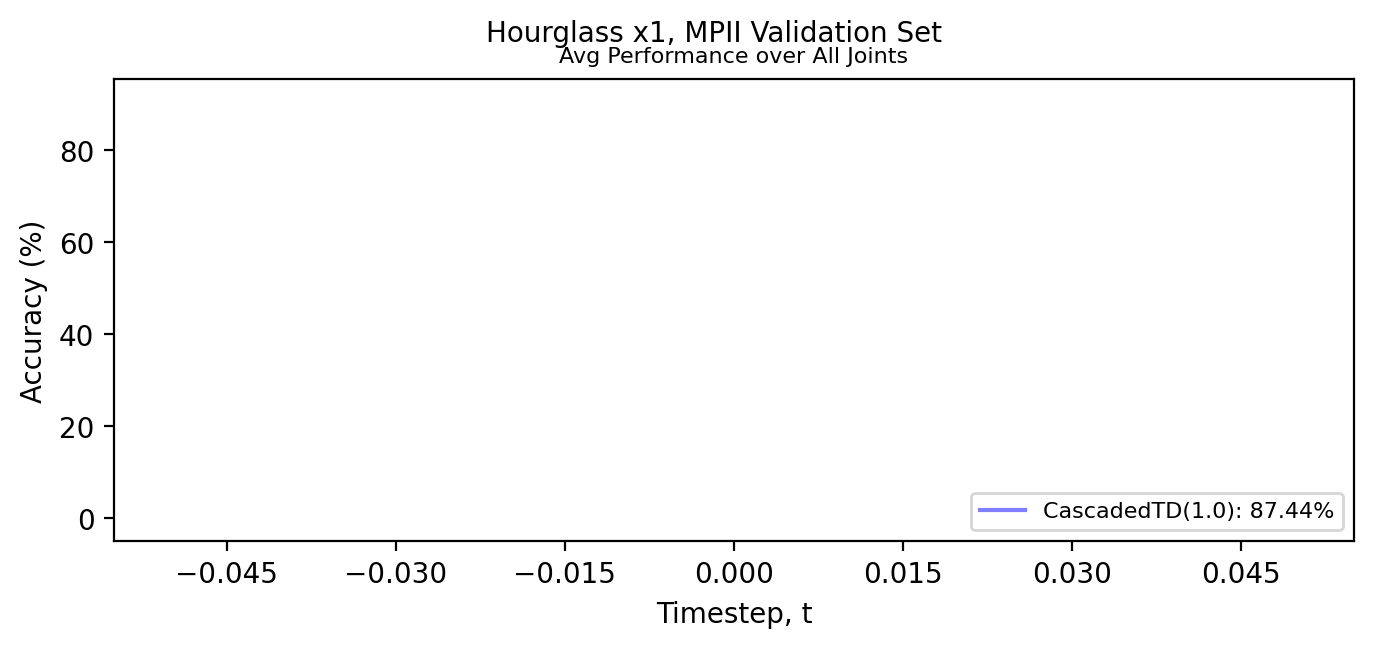

<Figure size 640x480 with 0 Axes>

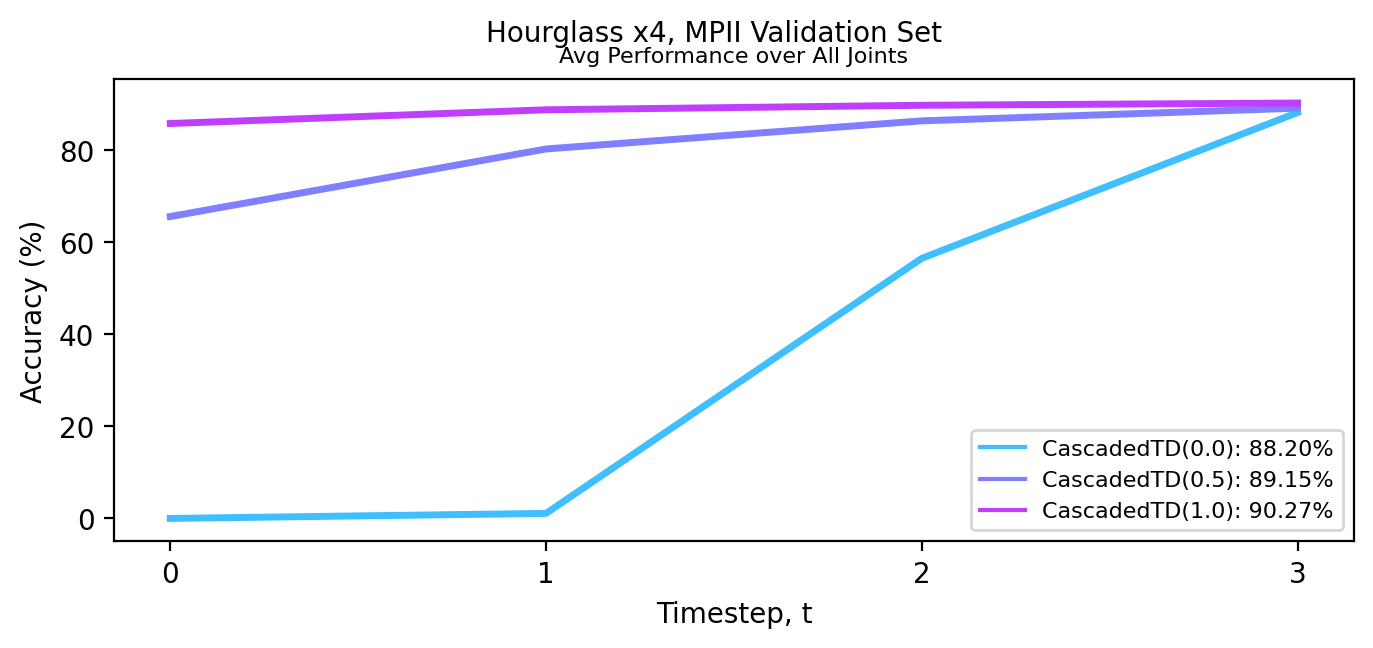

<Figure size 640x480 with 0 Axes>

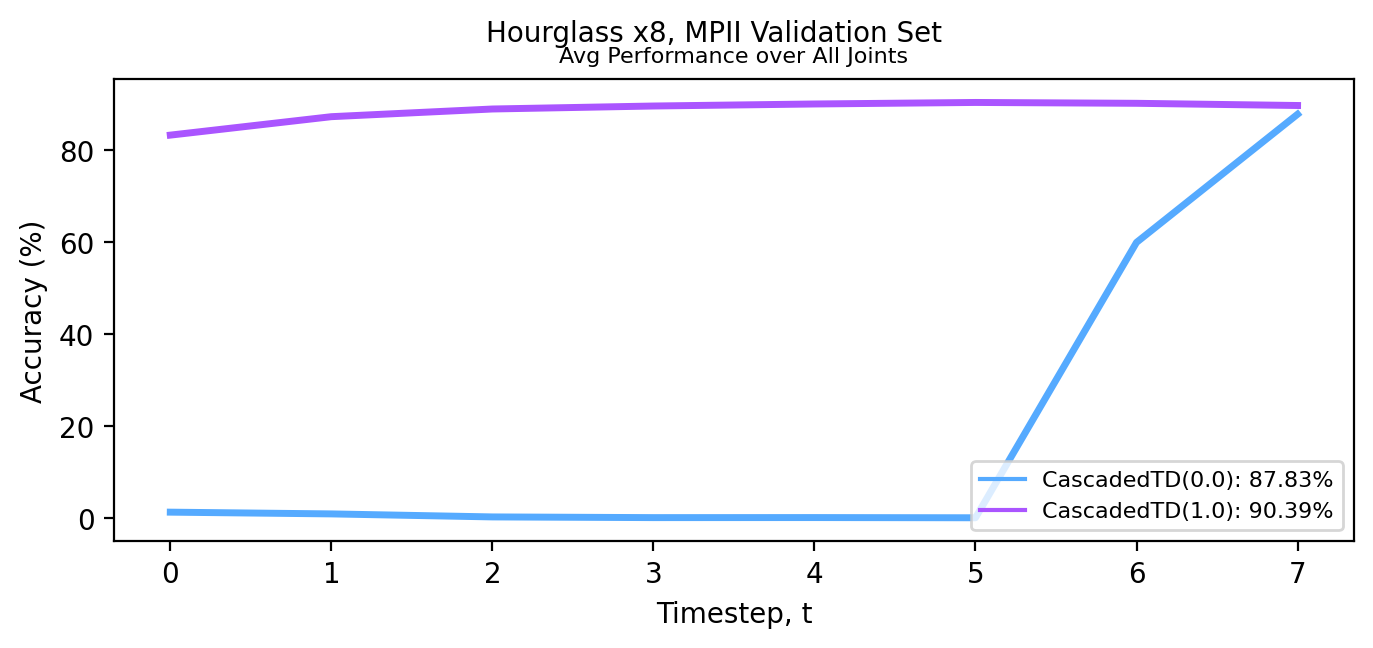

In [590]:
ylim_max = float(df.val.max())
ylim_max += 5

for model_key, td_model_df in df.groupby("model"):
  plot_figure(td_model_df, 
              dataset_name=DATASET_NAME, 
              ylim_min=df.val.min() - 5,
              ylim_max=ylim_max)

<Figure size 640x480 with 0 Axes>

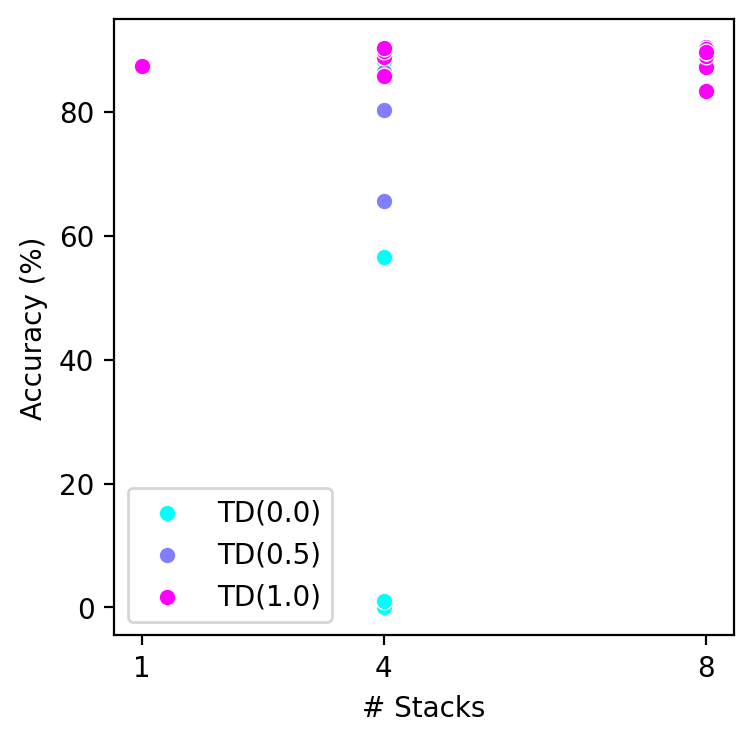

In [522]:
plt.figure(figsize=(4,4))
n_tds = df.td.unique().shape[0]
colors = plt.cm.cool(np.linspace(0, 1, n_tds))
for i, (td_key, td_df) in enumerate(df.groupby("td")):
  color = colors[i]
  label = f"TD({td_key})"
  g = sns.scatterplot(x="n_stacks", y="val", data=td_df, color=color, label=label)
g.set(xlabel="# Stacks", ylabel="Accuracy (%)")
# g.set_ylim(0, 91)
g.xaxis.set_major_locator(MaxNLocator(integer=True))
g.set_xticks(np.sort(df.n_stacks.unique()))
plt.show()

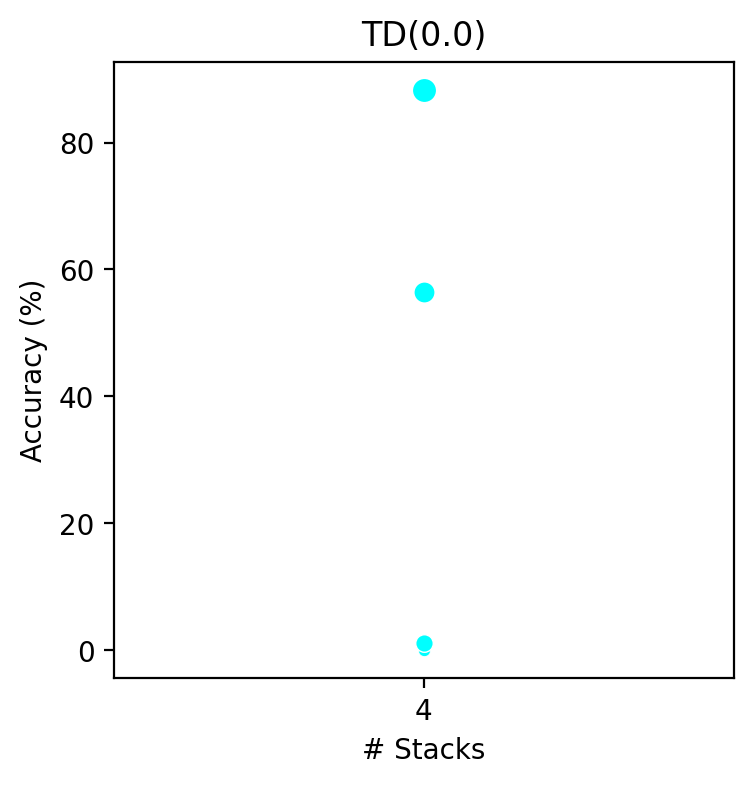

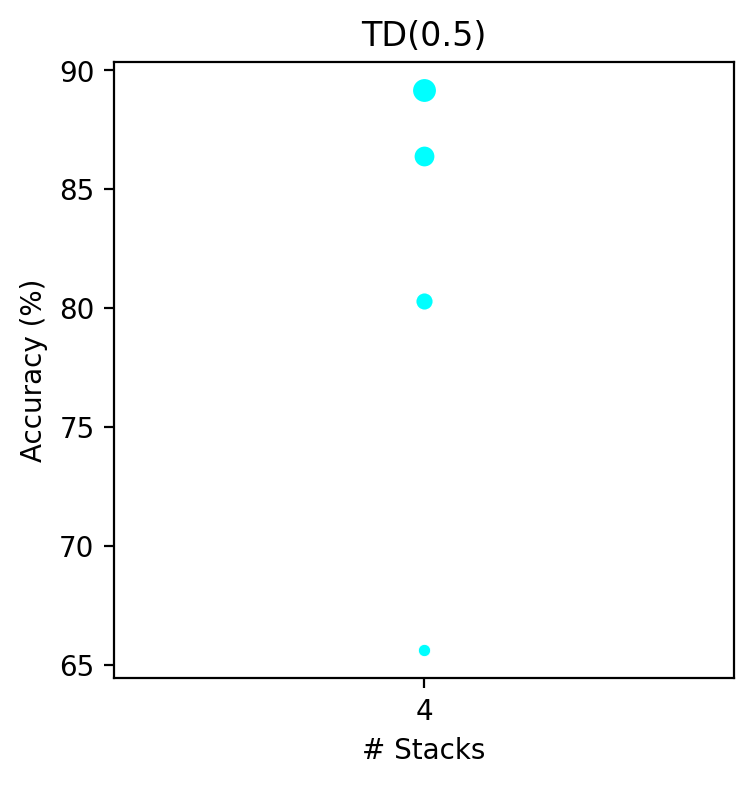

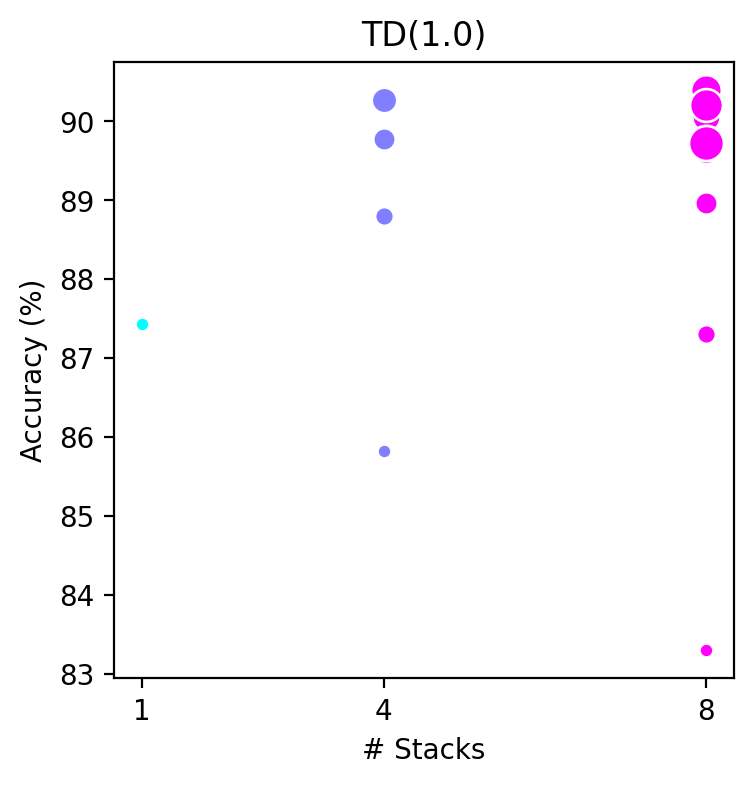

In [523]:
n_unique_stacks = df.n_stacks.unique().shape[0]
colors = plt.cm.cool(np.linspace(0, 1, n_unique_stacks))
for td_key, td_df in df.groupby("td"):
  plt.figure(figsize=(4,4))
  ax = plt.gca()
  for i, (n_stack, stack_df) in enumerate(td_df.groupby("n_stacks")):
    color = colors[i]
    title = f"TD({td_key})"
    for t, t_df in stack_df.groupby("t"):
      size = 20 * (t + 1)
      g = sns.scatterplot(
          x="n_stacks", 
          y="val", 
          data=t_df, 
          color=color, 
          s=size, 
          ax=ax
      )
    g.set(xlabel="# Stacks", ylabel="Accuracy (%)", title=title)
    g.xaxis.set_major_locator(MaxNLocator(integer=True))
    g.set_xticks(np.sort(td_df.n_stacks.unique()))
  plt.show()

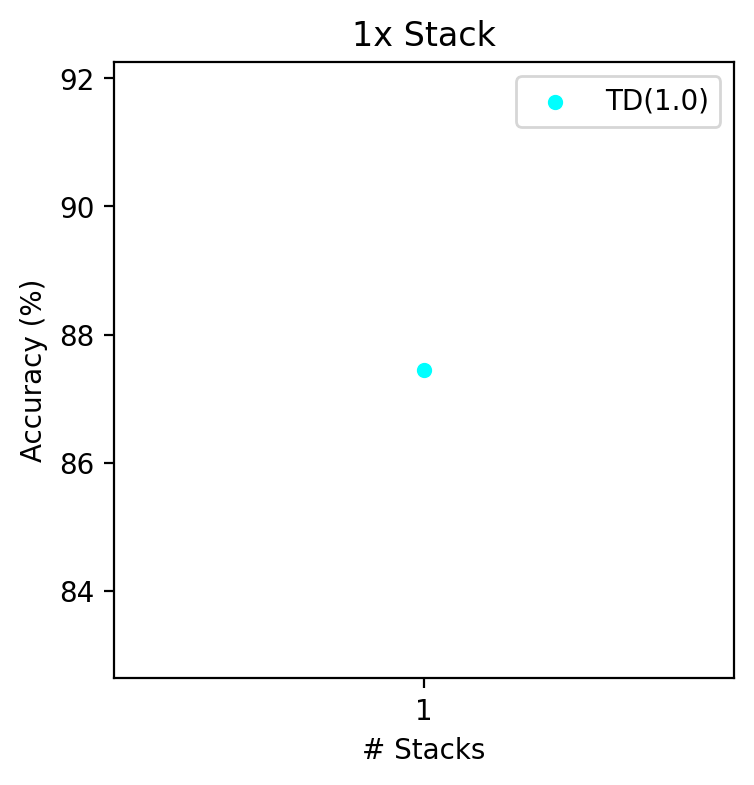

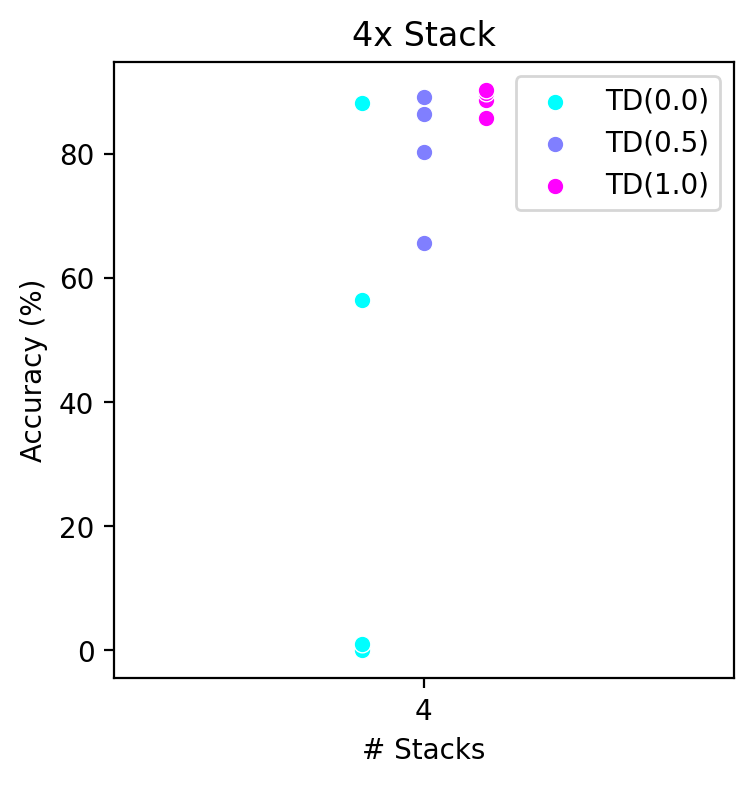

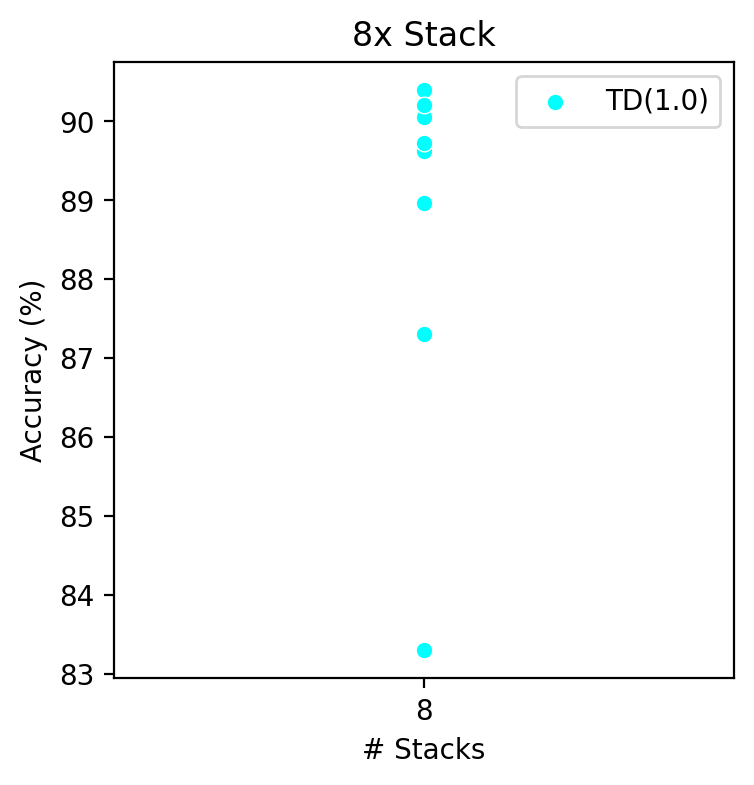

In [564]:
for stack_key, stack_df in df.groupby("n_stacks"):
  title = f"{stack_key}x Stack"
  plt.figure(figsize=(4,4))
  
  n_tds = stack_df.td.unique().shape[0]
  colors = plt.cm.cool(np.linspace(0, 1, n_tds))
  if n_tds > 1:
    offsets = np.linspace(0, 1, n_tds) - 0.5
    offsets = offsets * 0.2
    offsets = offsets[::-1]
  else:
    offsets = [0]
  for i, (td_key, td_df) in enumerate(stack_df.groupby("td")):
    color = colors[i]
    offset = offsets[i]
    td_df = td_df.copy()
    td_df.n_stacks = [ele - offset for ele in td_df.n_stacks]
    
    g = sns.scatterplot(
        x="n_stacks", 
        y="val", 
        data=td_df, 
        color=color, 
        label=f"TD({td_key})"
    )
  g.set(xlabel="# Stacks", ylabel="Accuracy (%)", title=title)
  
  g.set_xlim(stack_key-0.5, stack_key+0.5)
  g.xaxis.set_major_locator(MaxNLocator(integer=True))
  g.set_xticks(np.sort(stack_df.n_stacks.unique()))
  plt.show()

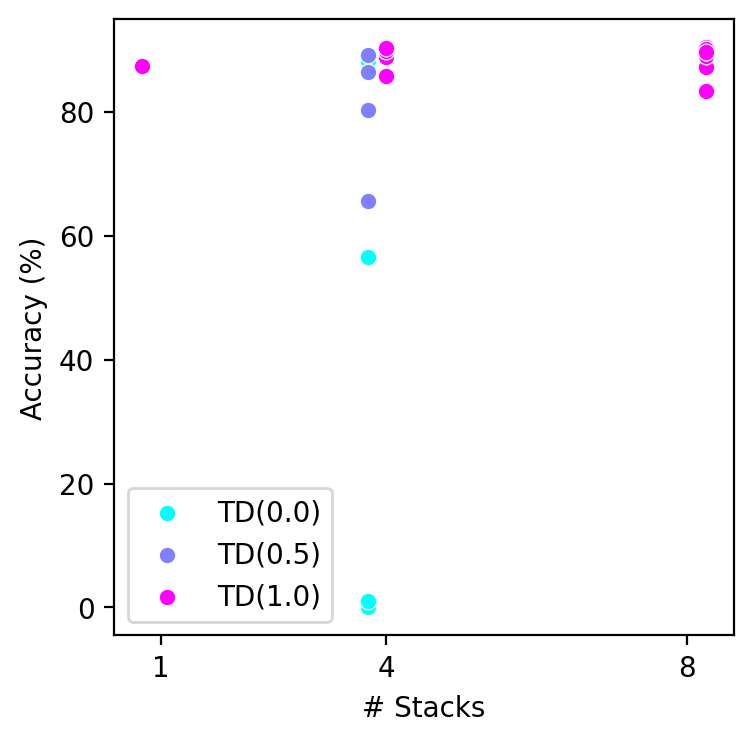

In [569]:
plt.figure(figsize=(4,4))
n_tds = df.td.unique().shape[0]
colors = plt.cm.cool(np.linspace(0, 1, n_tds))
for i, (td_key, td_df) in enumerate(df.groupby("td")):
  color = colors[i]
  label = f"TD({td_key})"
  
  if n_tds > 1:
    offsets = np.linspace(0, 1, n_tds) - 0.5
    offsets = offsets * 0.5
    offsets = offsets[::-1]
  else:
    offsets = [0]
    
  for i, (n_stack, stack_df) in enumerate(td_df.groupby("n_stacks")):
    offset = offsets[i]
    stack_df = stack_df.copy()
    stack_df.n_stacks = [ele - offset for ele in stack_df.n_stacks]
    label = label if i == 0 else None
    g = sns.scatterplot(x="n_stacks", y="val", data=stack_df, color=color, label=label)
g.set(xlabel="# Stacks", ylabel="Accuracy (%)")
# g.set_ylim(0, 91)
g.xaxis.set_major_locator(MaxNLocator(integer=True))
g.set_xticks(np.sort(df.n_stacks.unique()))
plt.show()